<a href="https://colab.research.google.com/github/dmitruy11/Diplom-2-year/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
pip install implicit

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
pip install catboost

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
pip install  LightFM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
import pandas as pd
import numpy as np
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset
from lightfm import LightFM
import datetime
import time
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from   xgboost  import XGBClassifier
from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
import pickle
from lightfm.evaluation import precision_at_k, auc_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
import pandas as pd
print(pd.__version__)

2.0.3


In [102]:
import pickle
from google.colab import files

Python


from google.colab import drive
drive.mount('/content/drive')

После выполнения этого кода вам будет предложено перейти по ссылке и аутентифицироваться в своей учетной записи Google. После успешной аутентификации вы получите доступ к своему Google Drive в Colab.

2. Получение пути к файлу на Google Drive

Теперь вы должны получить путь к файлу data.pickle на вашем Google Drive. Предположим, что файл находится в папке my_folder в корневой директории Google Drive. Вы можете получить полный путь к файлу следующим образом:

Python


file_path = '/content/drive/MyDrive/my_folder/data.pickle'

Замените my_folder на название соответствующей папки, в которой находится ваш файл data.pickle.

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
file_path = '/content/drive/MyDrive/diploma/data.pickle'

In [105]:
import pickle

with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [106]:
data

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,is_holiday,time_of_day,property,value,categoryid,parentid
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,Night,NaN,NaN,NaN,NaN
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,Night,NaN,NaN,NaN,NaN
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,Night,NaN,NaN,NaN,NaN
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,0,Night,NaN,NaN,NaN,NaN
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,0,Night,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755636,591435,view,261427,NaN,2015-08-01 03:13:05.939,3,8,5,1,0,Night,NaN,NaN,NaN,NaN
2755637,762376,view,115946,NaN,2015-08-01 03:30:13.142,3,8,5,1,0,Night,NaN,NaN,NaN,NaN
2755638,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2,8,5,1,0,Night,NaN,NaN,NaN,NaN
2755639,1184451,view,283392,NaN,2015-08-01 03:08:50.703,3,8,5,1,0,Night,NaN,NaN,NaN,NaN


In [107]:
need_cols =  ['data', 'itemid', 'visitorid', 'event']
df = data[need_cols]

Валидационный датасет
Создадим валидационный датасет, разбив данные по времени. Для этого возьмем последние семь дней данных в качестве валидационного периода.

In [108]:
validation_period = data['data'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train     = data[data['data'] < validation_period]
test = data[data['data'] >= validation_period]

In [109]:
#train = data[pd.to_datetime(df['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
#test = data[pd.to_datetime(df['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [110]:
print(f'train : {train.shape}')
print(f'test: {test.shape}')

train : (2640903, 15)
test: (114738, 15)


# XGBoost


## Для решения задачи классификации добавим в наши данные таргет - 1 при наличии тразакции и 0, если транзакции не было.

In [111]:
train['target'] = train['event'].apply(lambda x: 1 if  x=='transaction' else 0)
test['target'] = test['event'].apply(lambda x: 1 if  x=='transaction' else 0)

In [112]:
cat_features = ['visitorid', 'itemid', 'day_of_week',
       'Month', 'Day', 'Hour', 'minute', 'target']

In [113]:
cat_features

['visitorid',
 'itemid',
 'day_of_week',
 'Month',
 'Day',
 'Hour',
 'minute',
 'target']

In [114]:
# Случайная неполная выборка (нахождение класса большинства и его неполная выборка)
def random_under(df:pd.DataFrame, feature):

    target = df[feature].value_counts()

    if target.values[0]<target.values[1]:
        under = target.index.values[1]

    else:
        under = target.index.values[0]

    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]

    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)

    return df_1


def create_dataframe(visitor):

    visitor_df_array = []

    for x in visitor:

        #Создание массива, содержащего все данные о посетителе, кроме id
        v_df = data[data.visitorid == x]
        #Создание временного массива для хранения всех атрибутов посетителей
        temp = []
        #Заполнение первого элемента массива текущим индексом
        temp.append(x)
        #Заполнение массива количеством уникальных товаров, просмотренных посетителем (num_uniq_items_viewed)
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)
        # Заполнение массива количеством просмотров товаров посетителем независимо от того, тот же это продукт или нет (num_views_total)
        temp.append(v_df[v_df.event == 'view'].event.count())
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        # если посетитель купил хотя бы 1 товар, атрибуту присваивается значение 1, если посетитель ничего не купил, присваивается значение 0
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        visitor_df_array.append(temp)

    return pd.DataFrame(visitor_df_array, columns=['visitorid', 'num_uniq_items_viewed', 'num_views_total', 'bought_count', 'purchased'])

In [115]:
train = random_under(train, 'target')

Class 0: 21571
Class 1: 21571
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

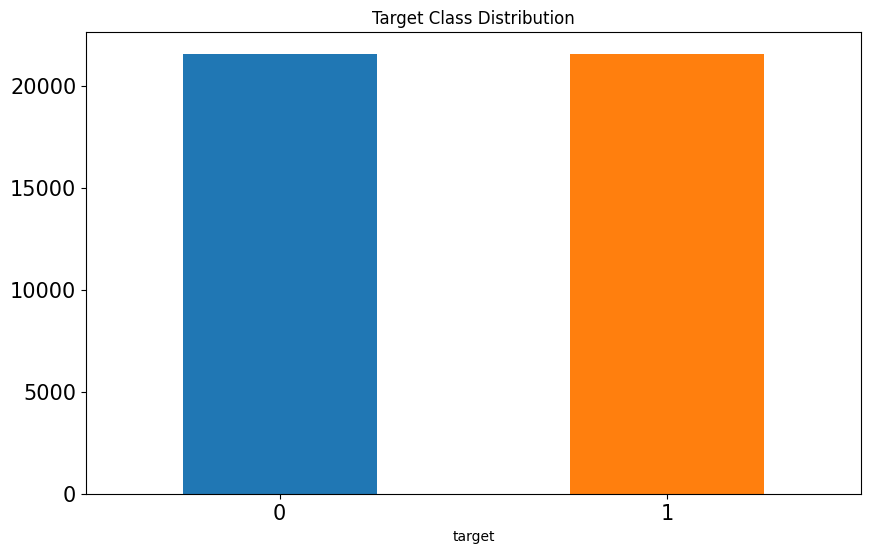

In [116]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['target'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0)

In [117]:
X_train = train[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
X_test = test[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
y_train = train['target']
y_test = test['target']

In [118]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [119]:
preds = xgb.predict(X_test)

In [120]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, preds)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, preds)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, preds)))

precision_score =  0.0119
recall_score =  0.5260
f1_score =  0.0233
accuracy =  0.6589


#CatBoostClassifier - это реализация алгоритма градиентного бустинга над решающими деревьями для задач классификации в библиотеке CatBoost.

In [121]:
from catboost import CatBoostClassifier

In [122]:
cb = CatBoostClassifier()

# Обучение модели
cb.fit(X_train, y_train)

Learning rate set to 0.051409
0:	learn: 0.6920091	total: 61.4ms	remaining: 1m 1s
1:	learn: 0.6909636	total: 74.9ms	remaining: 37.4s
2:	learn: 0.6899011	total: 92.5ms	remaining: 30.8s
3:	learn: 0.6891207	total: 112ms	remaining: 27.8s
4:	learn: 0.6877441	total: 139ms	remaining: 27.7s
5:	learn: 0.6869631	total: 181ms	remaining: 30s
6:	learn: 0.6862354	total: 233ms	remaining: 33s
7:	learn: 0.6853130	total: 248ms	remaining: 30.8s
8:	learn: 0.6846871	total: 261ms	remaining: 28.8s
9:	learn: 0.6840508	total: 273ms	remaining: 27.1s
10:	learn: 0.6836122	total: 291ms	remaining: 26.2s
11:	learn: 0.6830951	total: 303ms	remaining: 24.9s
12:	learn: 0.6826914	total: 324ms	remaining: 24.6s
13:	learn: 0.6823478	total: 351ms	remaining: 24.7s
14:	learn: 0.6820238	total: 385ms	remaining: 25.3s
15:	learn: 0.6816262	total: 426ms	remaining: 26.2s
16:	learn: 0.6813228	total: 468ms	remaining: 27.1s
17:	learn: 0.6809534	total: 502ms	remaining: 27.4s
18:	learn: 0.6804677	total: 530ms	remaining: 27.4s
19:	learn: 0

In [123]:
pred = cb.predict(X_test)

In [124]:

print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, pred)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, pred)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, pred)))

precision_score =  0.0122
recall_score =  0.5248
f1_score =  0.0233
accuracy =  0.6671


precision_score =  0.0117

recall_score =  0.4314

f1_score =  0.0228

accuracy =  0.6941

# Коллаборативная фильтрация

###  список всех идентификаторов клиентов.

In [125]:
all_visitors = data.visitorid.sort_values().unique()
all_visitors.size

1407580

###  список клиентов, которые что-то купили.

In [126]:
buy_visitors = data[data.event == 'transaction'].visitorid.sort_values().unique()
buy_visitors.size

11719

In [127]:
view_visitors = list([x for x in all_visitors if x not in buy_visitors])

In [128]:
buy_visitors_df = create_dataframe(buy_visitors)

In [129]:
buy_visitors_df.head(3)

,visitorid,num_uniq_items_viewed,num_views_total,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1


In [130]:
trainCF = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testCF = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

### список, который содержит заказы клиентов и элементы внутри них.

In [131]:
purchased_items = []

for customer in buy_visitors:
    purchased_items.append(list(data.loc[(data.visitorid == customer) & (data.transactionid.notnull())].itemid.values))

 ### функция, которая выдавала бы список товаров, которые были куплены вместе с указанным товаром.

In [132]:
def recommender_bought_bought(item_id, purchased_items):

    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x

    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))

    return recommender_list

###  функцию расчета метрики.

In [133]:
def metrik_p3(df):
  res = len(set(top3) & set(df))
  p_3= round((res/3),2)
  return p_3

 ###  введем идентификатор элемента, получим список элементов, которые появились в заказах с указанным элементом.

In [134]:
recommender_bought_bought(302422, purchased_items)[:3]

[105792, 200793, 12836]

 список ТОП-3 товаров.

In [135]:
top3 = list(train.itemid.value_counts()[:3].index)
top3

[461686, 119736, 213834]

 ## метрика на 30 произвольных записи из тестовой части.

In [136]:
test_sample = testCF[testCF['event']=='transaction'].sample(n=30)

In [137]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,is_holiday,time_of_day,property,value,categoryid,parentid
1182880,560891,transaction,417156,16304.0,2015-09-02 14:50:52.981,14,9,2,0,0,Afternoon,NaN,NaN,NaN,NaN
1288233,1200257,transaction,210525,390.0,2015-09-08 07:29:53.100,7,9,1,0,0,Morning,NaN,NaN,NaN,NaN
1136974,1104771,transaction,419712,16616.0,2015-08-31 03:13:19.517,3,8,0,0,0,Night,NaN,NaN,NaN,NaN


In [138]:
test_sample['1'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[0:1])
test_sample['2'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[1:2])
test_sample['3'] =test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[2:3])

In [139]:
def replace_col(df):
  df =  df.apply(lambda x: str(x).replace('[', ''))
  df =  df.apply(lambda x: str(x).replace(']', ''))
  return df

In [140]:
test_sample['1'] =  replace_col(test_sample['1'])
test_sample['2'] =  replace_col(test_sample['2'])
test_sample['3'] =  replace_col(test_sample['3'])
test_sample['1'] = test_sample['1'].apply(lambda x: top3[0] if x=='' else x)
test_sample['2'] = test_sample['2'].apply(lambda x: top3[1] if x=='' else x)
test_sample['3'] = test_sample['3'].apply(lambda x: top3[2] if x=='' else x)

In [141]:
test_sample['pred'] = test_sample[['1', '2', '3']].values.tolist()

In [142]:
test_sample['p@3'] = 0

In [143]:
index = test_sample.pred.index
for i in index:
  test_sample['p@3'][i] = metrik_p3(test_sample['pred'][i])

In [144]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,is_holiday,time_of_day,property,value,categoryid,parentid,1,2,3,pred,p@3
1182880,560891,transaction,417156,16304.0,2015-09-02 14:50:52.981,14,9,2,0,0,Afternoon,NaN,NaN,NaN,NaN,461686,119736,213834,"[461686, 119736, 213834]",1.0
1288233,1200257,transaction,210525,390.0,2015-09-08 07:29:53.100,7,9,1,0,0,Morning,NaN,NaN,NaN,NaN,461686,119736,213834,"[461686, 119736, 213834]",1.0
1136974,1104771,transaction,419712,16616.0,2015-08-31 03:13:19.517,3,8,0,0,0,Night,NaN,NaN,NaN,NaN,218881,296795,173313,"[218881, 296795, 173313]",0.0


In [145]:
# Precision@3
metric = round(test_sample['p@3'].mean(),2)
print('Mean Average Precision at 3: {:.2}'.format(metric))

Mean Average Precision at 3: 0.47


# ALS

In [146]:
dfALS = data.copy()

In [147]:
dfALS['event_scores'] = dfALS['event'].apply(
    lambda x: 1 if x == 'view' else 5 if x == 'addtocart' else 25 if x == 'transaction' else 0
)

In [148]:
dfALS.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,is_holiday,time_of_day,property,value,categoryid,parentid,event_scores
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,0,Night,NaN,NaN,NaN,NaN,1
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,0,Night,NaN,NaN,NaN,NaN,1
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,0,Night,NaN,NaN,NaN,NaN,1


 ###  преобразуем стобцы их в разреженную матрицу для экономии места и чтобы наша модель была способна вычислять все возможные взаимодействия в наборе данных. По  модулю scipy.sparse.

In [149]:
dfALS['visitorid'] = dfALS['visitorid'].astype("category").cat.as_ordered()
dfALS['itemid'] = dfALS['itemid'].astype("category").cat.as_ordered()

sparse_item_user = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['itemid'], dfALS['visitorid'])))
sparse_user_item = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['visitorid'], dfALS['itemid'])))

In [150]:
trainALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [151]:
trainALS['visitorid'] = trainALS['visitorid'].astype("category").cat.as_ordered()
trainALS['itemid'] = trainALS['itemid'].astype("category").cat.as_ordered()

testALS['visitorid'] = testALS['visitorid'].astype("category").cat.as_ordered()
testALS['itemid'] = testALS['itemid'].astype("category").cat.as_ordered()

In [152]:
sparse_train_item_user = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['itemid'], trainALS['visitorid'])))
sparse_train_user_item = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['visitorid'], trainALS['itemid'])))

In [153]:
sparse_test_item_user = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['itemid'], testALS['visitorid'])))
sparse_test_user_item = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['visitorid'], testALS['itemid'])))

 ### матрицы готовы, мы можем параметризовать и подогнать нашу модель.

#### Используемые параметры являются довольно стандартными: латентные_факторы и n_iter параметры, которые изменяются чаще, поскольку их увеличение увеличило бы прогностическую силу нашей модели за счет более высоких вычислений, использования памяти и вероятности переобучения для нашей оценки.

In [154]:
latent_factors = 20
regularization = 0.1
n_iter = 20
alpha = 40

conf_matrix = (sparse_train_item_user * alpha).astype('double')

model = AlternatingLeastSquares(
    factors=latent_factors,
    regularization=regularization,
    iterations=n_iter
)

model.fit(conf_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [155]:
p_at3_als = mean_average_precision_at_k(model, sparse_train_item_user, sparse_test_item_user, K=3)
print('Mean Average Precision at 3: {:.2%}'.format(p_at3_als))

  0%|          | 0/119873 [00:00<?, ?it/s]

Mean Average Precision at 3: 0.13%


In [156]:
def recommend_item_to_user(model, visitorid, sparse_test_item_user, n=3):
    recommended = model.recommend(visitorid, sparse_test_item_user[visitorid], n)
    return recommended


def similar_items_to_item(model, itemid, n=3):
    similar = model.similar_items(itemid, n)
    return similar

In [157]:
userid = 12453
recommended_items = recommend_item_to_user(model, userid, sparse_test_item_user)
print(f"Recommended items for user {userid}:\n{recommended_items[0]}")

Recommended items for user 12453:
[389532 748040 138131]


In [158]:
itemid =4560
similar_items = similar_items_to_item(model, itemid)
print(f"Similar items to {itemid}:\n{similar_items[0]}")

Similar items to 4560:
[   4560 1347367  550853]


# LightFM
## LightFM — это реализация на Python ряда популярных алгоритмов рекомендаций как для неявной, так и для явной обратной связи.

In [159]:
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

In [160]:

from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset


trainLFM = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testLFM = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [161]:
validation_period = data['data'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train     = data[data['data'] < validation_period]
test = data[data['data'] >= validation_period]

In [162]:

all_visitorids = data.visitorid.unique()
all_itemids = data.itemid.unique()


In [163]:

dataset = Dataset()

In [164]:
dataset.fit(users=all_visitorids, items=all_itemids)

In [165]:

train_coo = dataset.build_interactions(trainLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [166]:

test_coo = dataset.build_interactions(testLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [167]:
modelLFM = LightFM(loss='warp', no_components=50, random_state=42)
modelLFM.fit(train_coo[0], epochs=20)

In [168]:
p_at3 = precision_at_k(modelLFM, test_coo[0], k=3).mean()
print('Mean Average Precision at 3: {:.2%}'.format(p_at3))

Mean Average Precision at 3: 0.76%


In [169]:
import numpy as np
scores = modelLFM.predict(1, np.arange(len(all_itemids)))
top = np.argsort(-scores)[:3]
item_lagels = {v:k for k, v in dataset.mapping()[2].items()}

In [170]:
[item_lagels[k] for k in top]

[461686, 7943, 416017]

In [171]:
#количество пользователей и товаров в обучающих данных
df = data[['itemid']]
items = df.to_numpy()

def sample_recommendation(model, data, user_ids):

    n_users, n_items = data.shape

    #generate recommendations for each user we input
    for user_id in user_ids:

        #movies our model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))

        #rank them in order of most liked to least
        top_items = items[np.argsort(-scores)][:3]

        print(top_items)

In [172]:
sample_recommendation(modelLFM, test_coo[0], [7])

[[286057]
 [224900]
 [369638]]


In [173]:
n_users, n_items = test_coo[0].shape

for user_id in [1]:
    scores = modelLFM.predict(user_id, np.arange(n_items))
    top_items = items[np.argsort(-scores)][:3]
    print(top_items)

[[286057]
 [224900]
 [369638]]


In [174]:
sample_recommendation(modelLFM, test_coo[1], [6])

[[286057]
 [224900]
 [369638]]


In [175]:
def get_recommendations(model, data, user_id, num_recs=3):
    n_items = data['itemid'].nunique()
    user_ids = np.array([user_id] * n_items)
    item_ids = np.arange(n_items)

    scores = model.predict(user_ids, item_ids)
    top_item_indices = np.argsort(-scores)[:num_recs]
    top_items = data['itemid'].values[top_item_indices]

    return top_items

In [176]:
user_id = 46666
top_recommendations = get_recommendations(modelLFM, data, user_id)
print(f"Рекомендуемые товары для пользователя {user_id}: {top_recommendations}")

Рекомендуемые товары для пользователя 46666: [286057 224900 453219]


# Сохранение

In [ ]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Сохранение модели LightFM в корневой директории Google Drive
import pickle

with open('/content/drive/MyDrive/diploma/lightfm_model.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Модель успешно сохранена в Google Drive')

In [ ]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Сохранение модели LightFM в корневой директории Google Drive
import pickle

with open('/content/drive/MyDrive/diploma/lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Модель успешно сохранена в Google Drive')

Чтобы сохранить файл lightfm_model.pickle на локальный диск вашего компьютера, вы можете использовать следующий код:

In [ ]:
with open('lightfm_model.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
visitors_items_mapping = dataset.mapping()

In [ ]:
with open('lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(visitors_items_mapping , f, protocol=pickle.HIGHEST_PROTOCOL)

# чтение

In [ ]:
with open('lightfm_data_mapping.pickle', 'rb') as f:
    loaded_model1 = pickle.load(f)

In [ ]:
loaded_model1

In [ ]:
with open('lightfm_model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
loaded_model

In [ ]:
import numpy as np

# Получаем размеры взаимодействий пользователей с элементами
n_users, n_items = test_coo[0].shape

# Укажите user_id, для которого нужно получить рекомендации
user_id = 44 # Замените на нужный user_id

# Получаем рекомендации для указанного user_id
scores = modelLFM.predict(user_id, np.arange(n_items))
top_items = items[np.argsort(-scores)][:3]
print(f"Рекомендации для user_id {user_id}:")
print(top_items)